# California Housing and Clustering

In [70]:
import pandas as pd
import os

HOUSING_PATH = os.path.join("datasets", "housing")

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [71]:
# drop all columns aside from median income, latitude and longitude
housing_reduced = housing[['median_income', 'latitude', 'longitude']]
housing_reduced.head()

,median_income,latitude,longitude
0,8.3252,37.88,-122.23
1,8.3014,37.86,-122.22
2,7.2574,37.85,-122.24
3,5.6431,37.85,-122.25
4,3.8462,37.85,-122.25


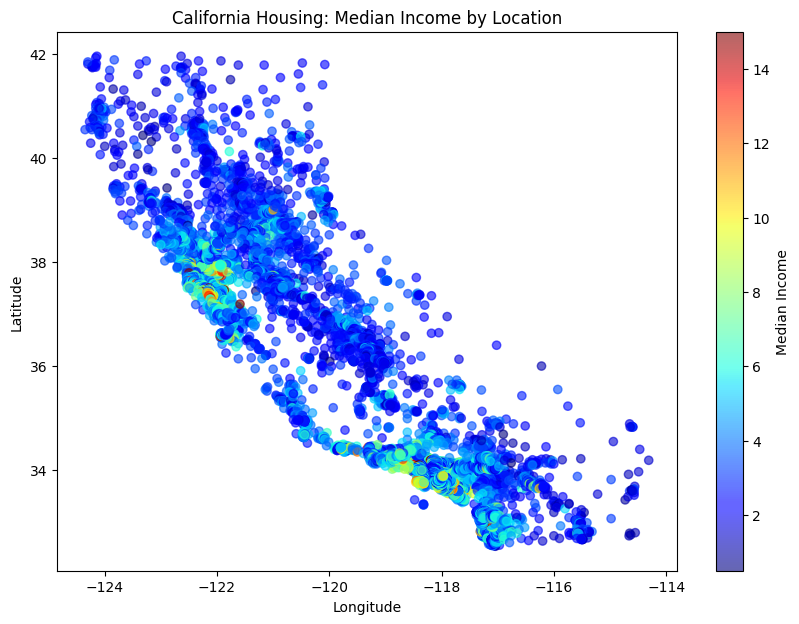

In [72]:
# plot the data: x as longitude, y as latitude, color by median income, use dots (not circles of varying size)
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
plt.scatter(housing_reduced['longitude'], housing_reduced['latitude'],
            c=housing_reduced['median_income'], cmap=plt.get_cmap('jet'),
            alpha=0.6, marker='o')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('California Housing: Median Income by Location')
cbar = plt.colorbar()
cbar.set_label('Median Income')
plt.show()

In [73]:
# scale all features for better kmean performance
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
housing_scaled = scaler.fit_transform(housing_reduced)
housing_scaled[:5]

array([[ 2.34476576,  1.05254828, -1.32783522],
       [ 2.33223796,  1.04318455, -1.32284391],
       [ 1.7826994 ,  1.03850269, -1.33282653],
       [ 0.93296751,  1.03850269, -1.33781784],
       [-0.012881  ,  1.03850269, -1.33781784]])

In [96]:
# perform KMeans clustering on the reduced dataset with different number of clusters
from sklearn.cluster import KMeans
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(housing_scaled)
                for k in range(2, 22)]

In [97]:
inertia = [model.inertia_ for model in kmeans_per_k]

In [98]:
from sklearn.metrics import silhouette_score
silhouette_scores = [silhouette_score(housing_scaled, model.labels_)
                     for model in kmeans_per_k]

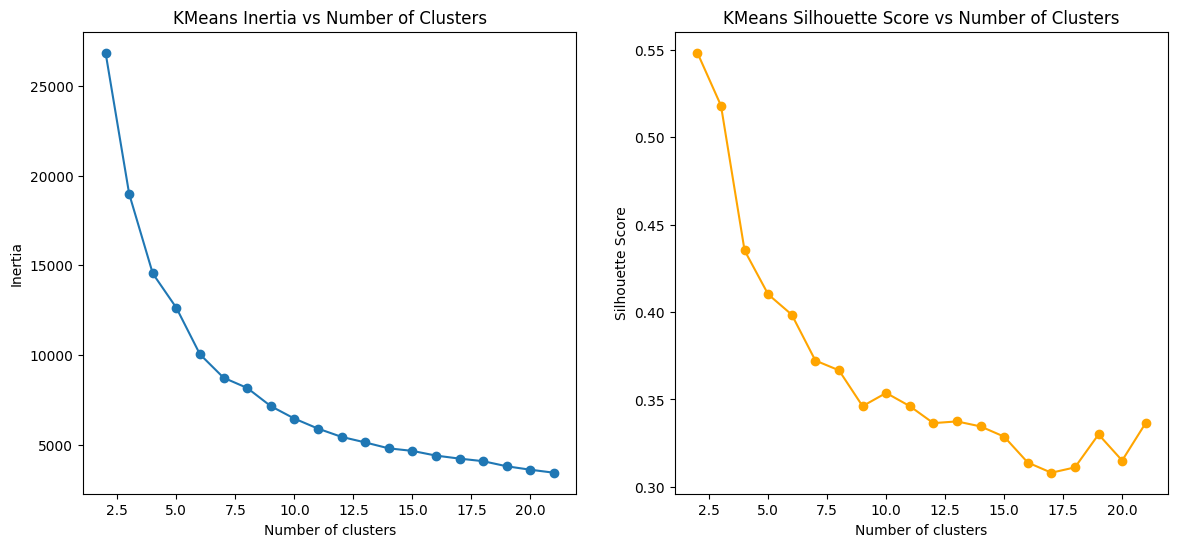

In [99]:
# plot inertia and silhouette scores
plt.figure(figsize=(14,6))
plt.subplot(1, 2, 1)
plt.plot(range(2, 22), inertia, marker='o')
plt.title('KMeans Inertia vs Number of Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

plt.subplot(1, 2, 2)
plt.plot(range(2, 22), silhouette_scores, marker='o', color='orange')
plt.title('KMeans Silhouette Score vs Number of Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

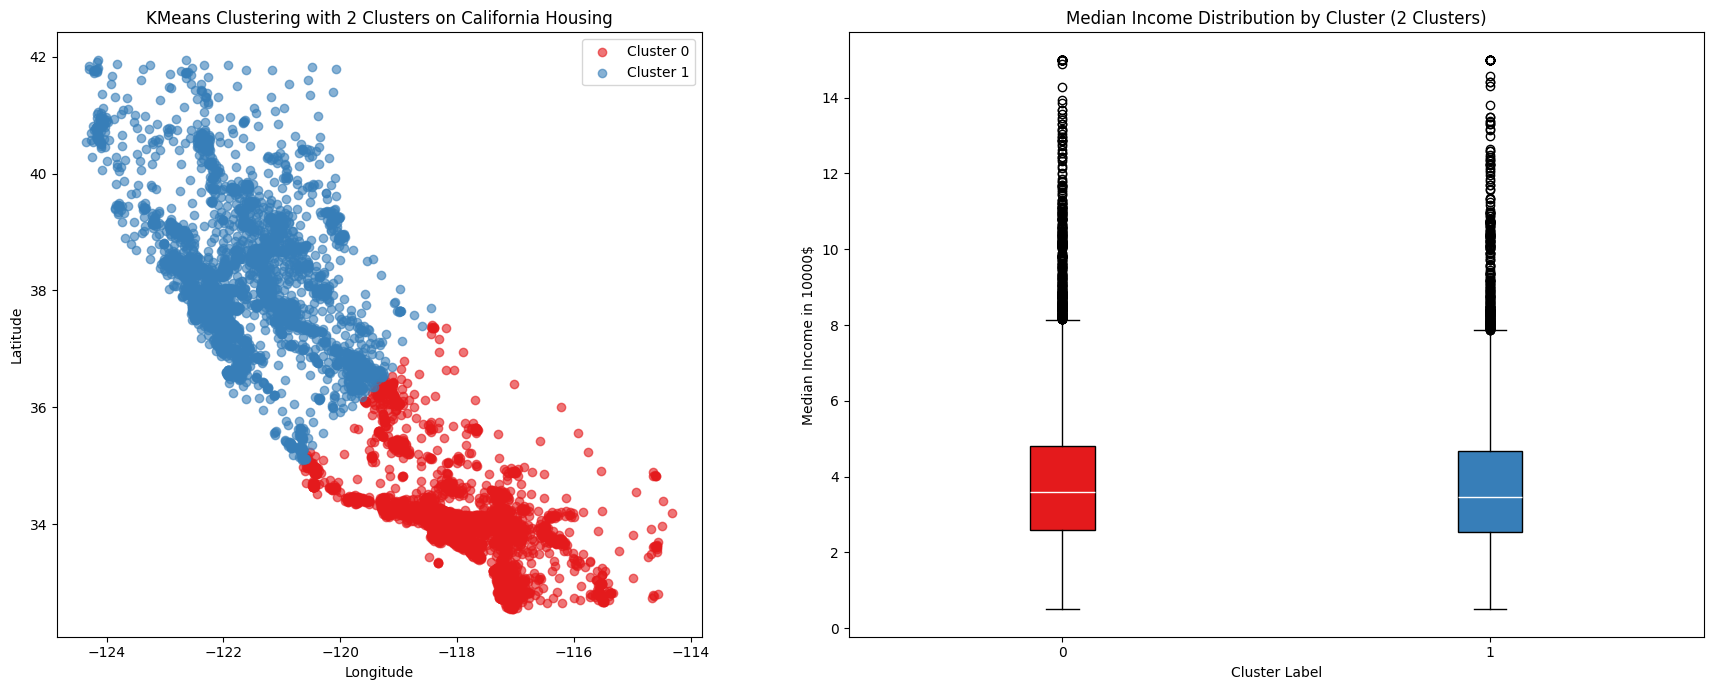

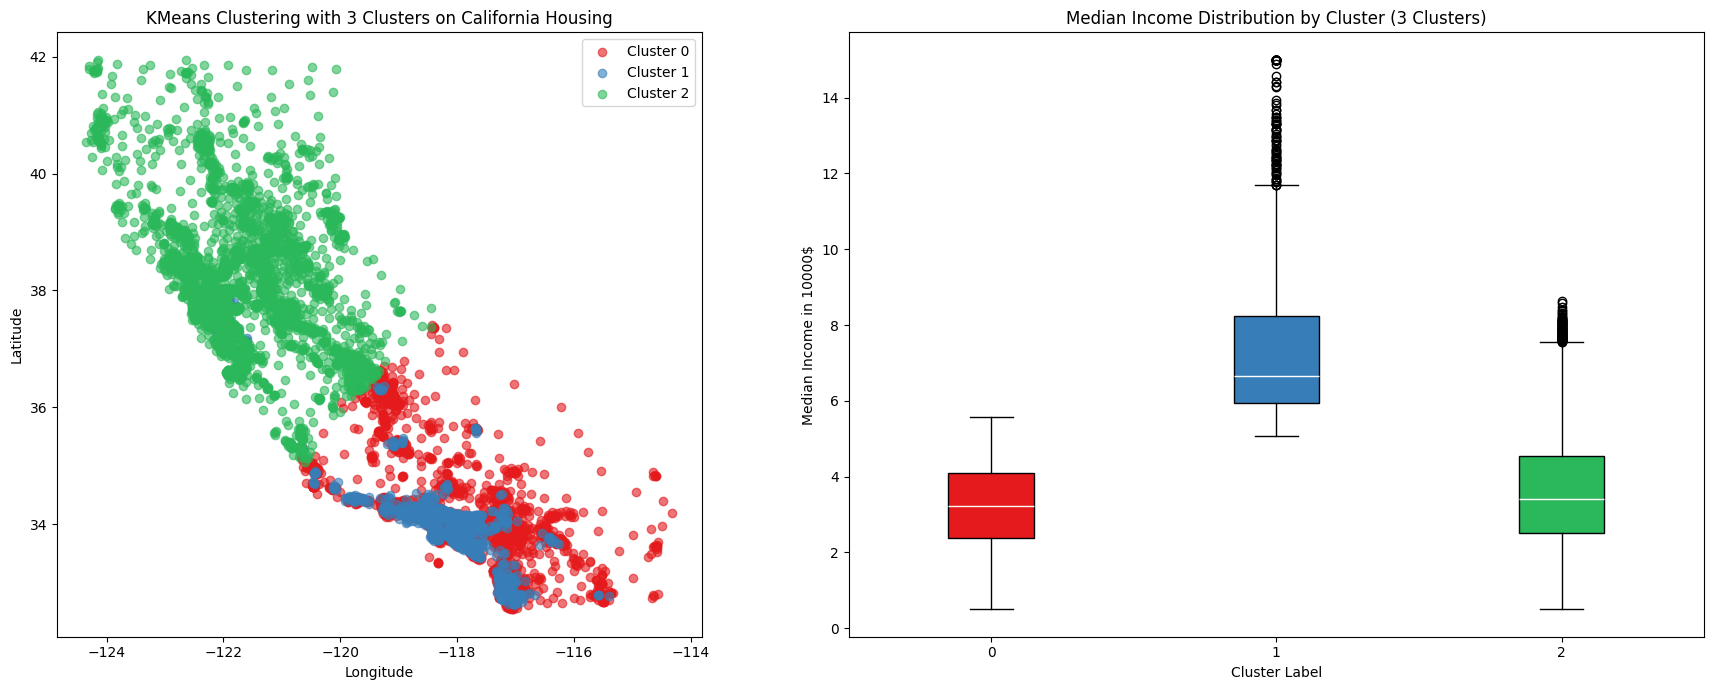

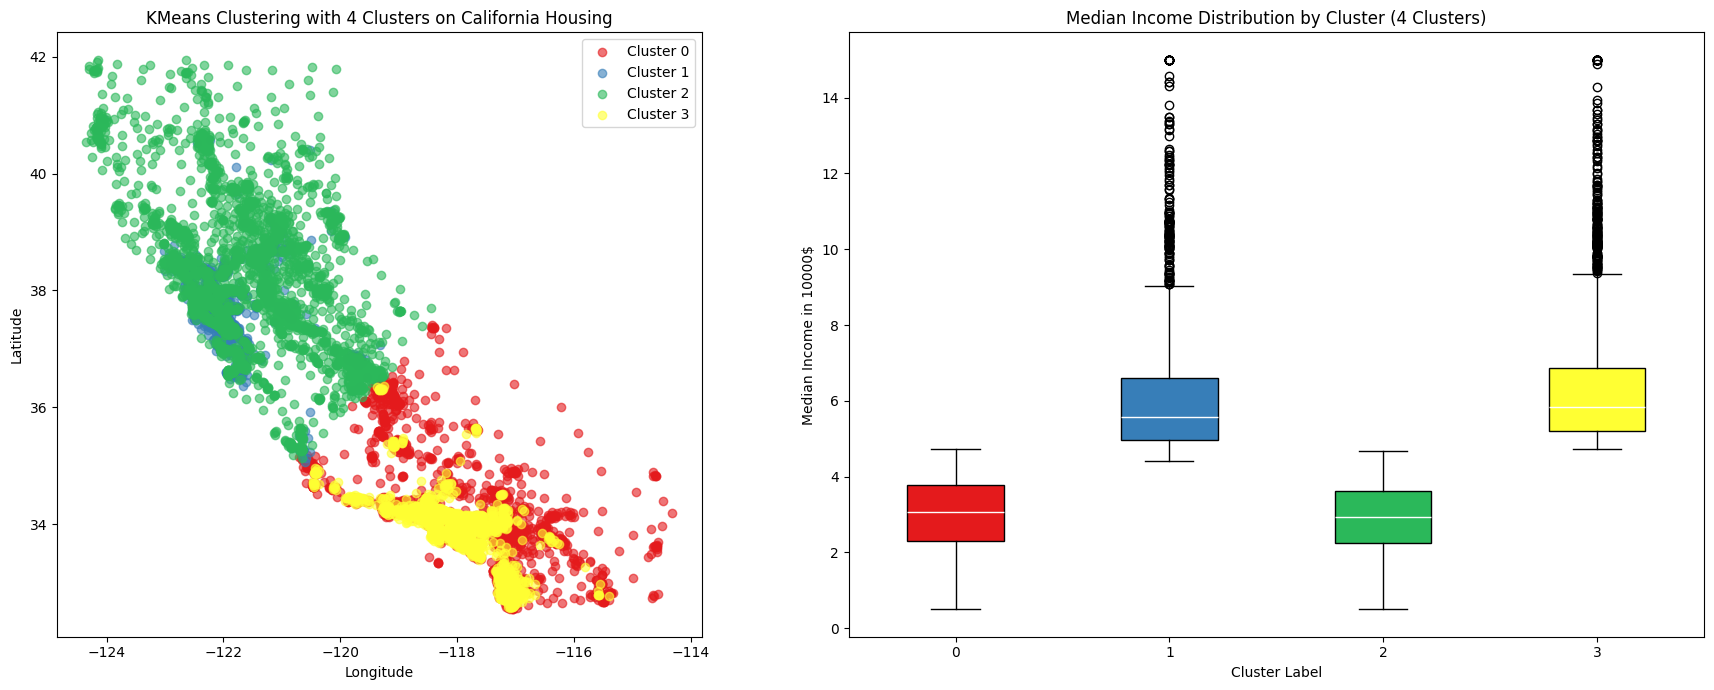

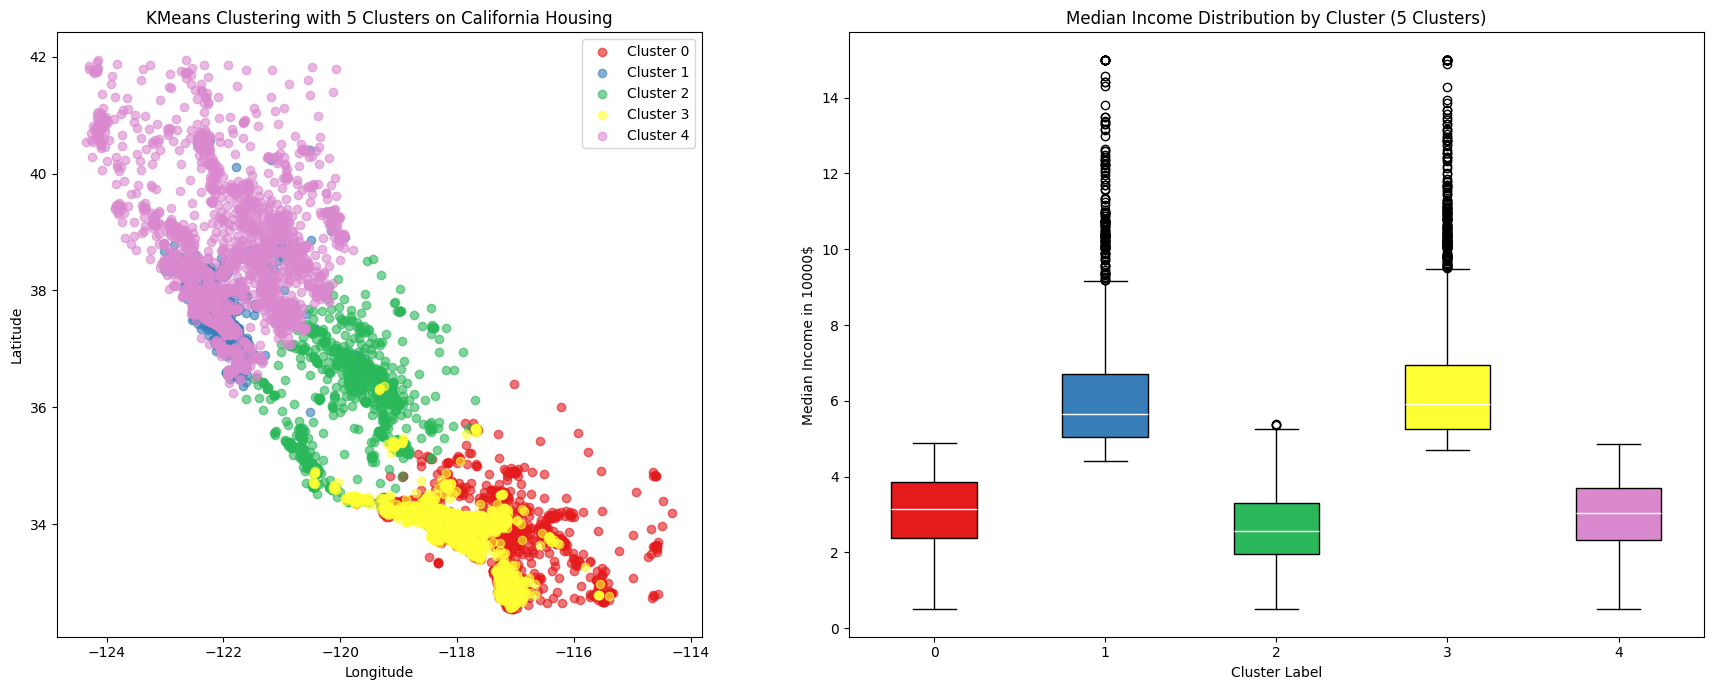

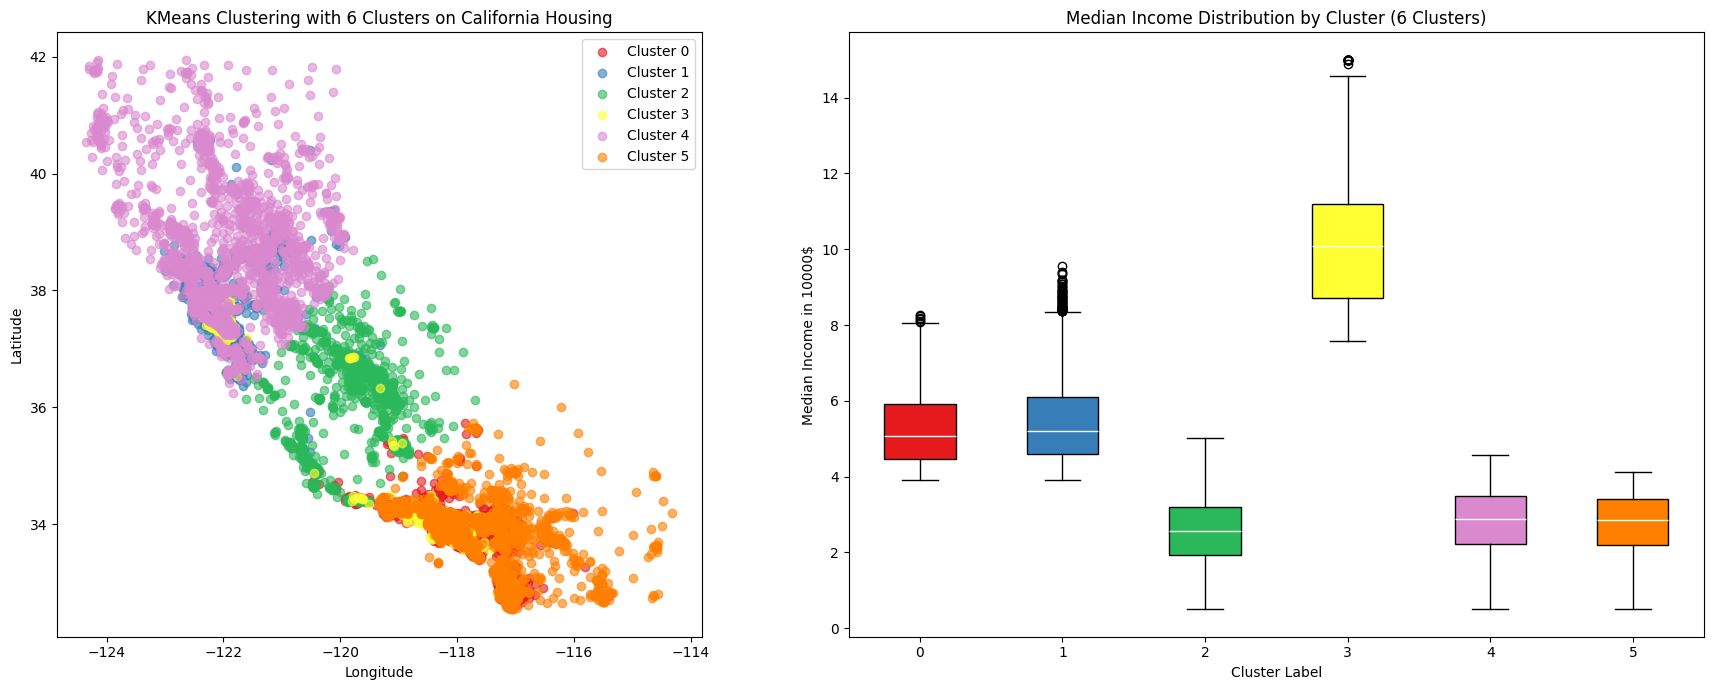

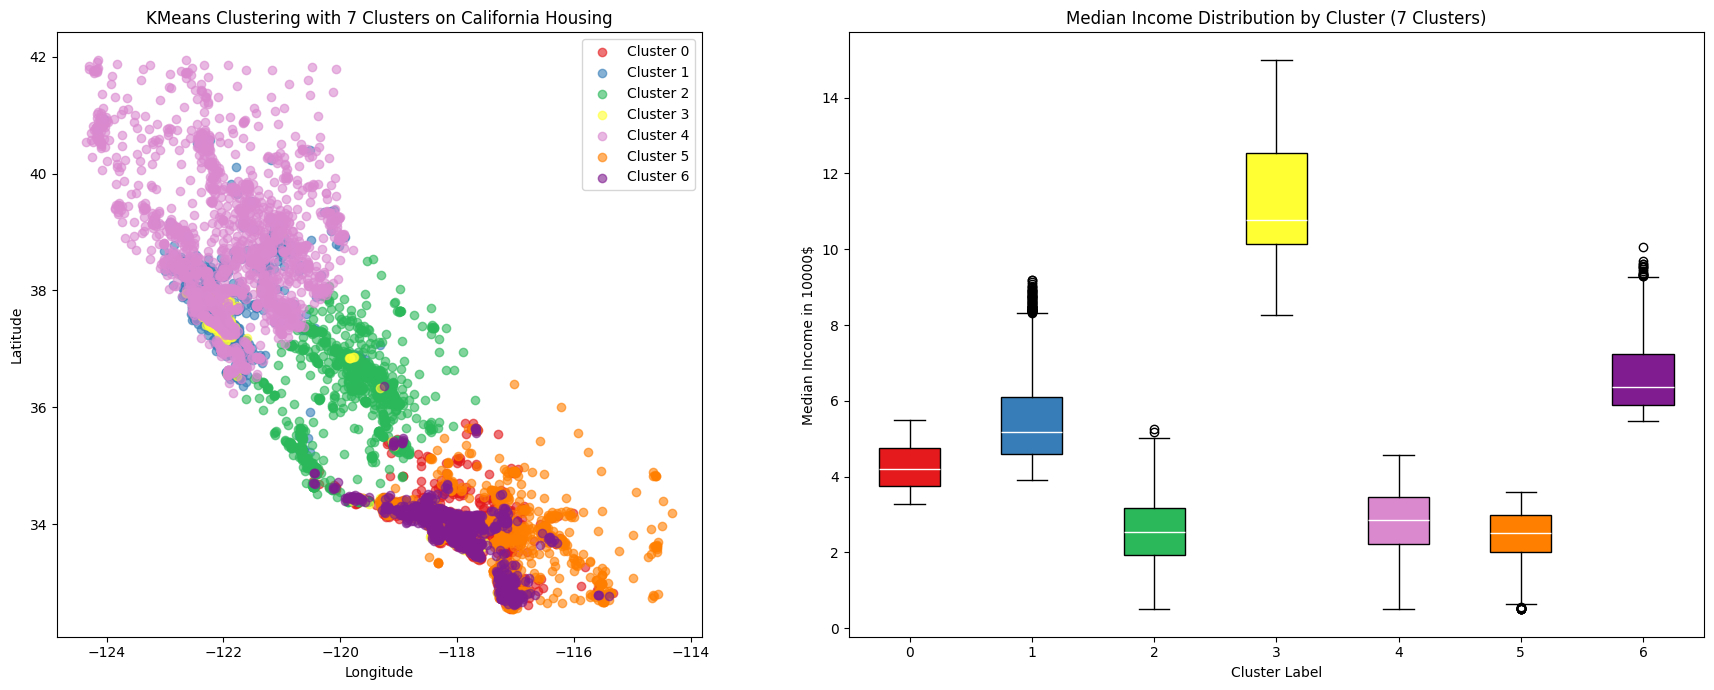

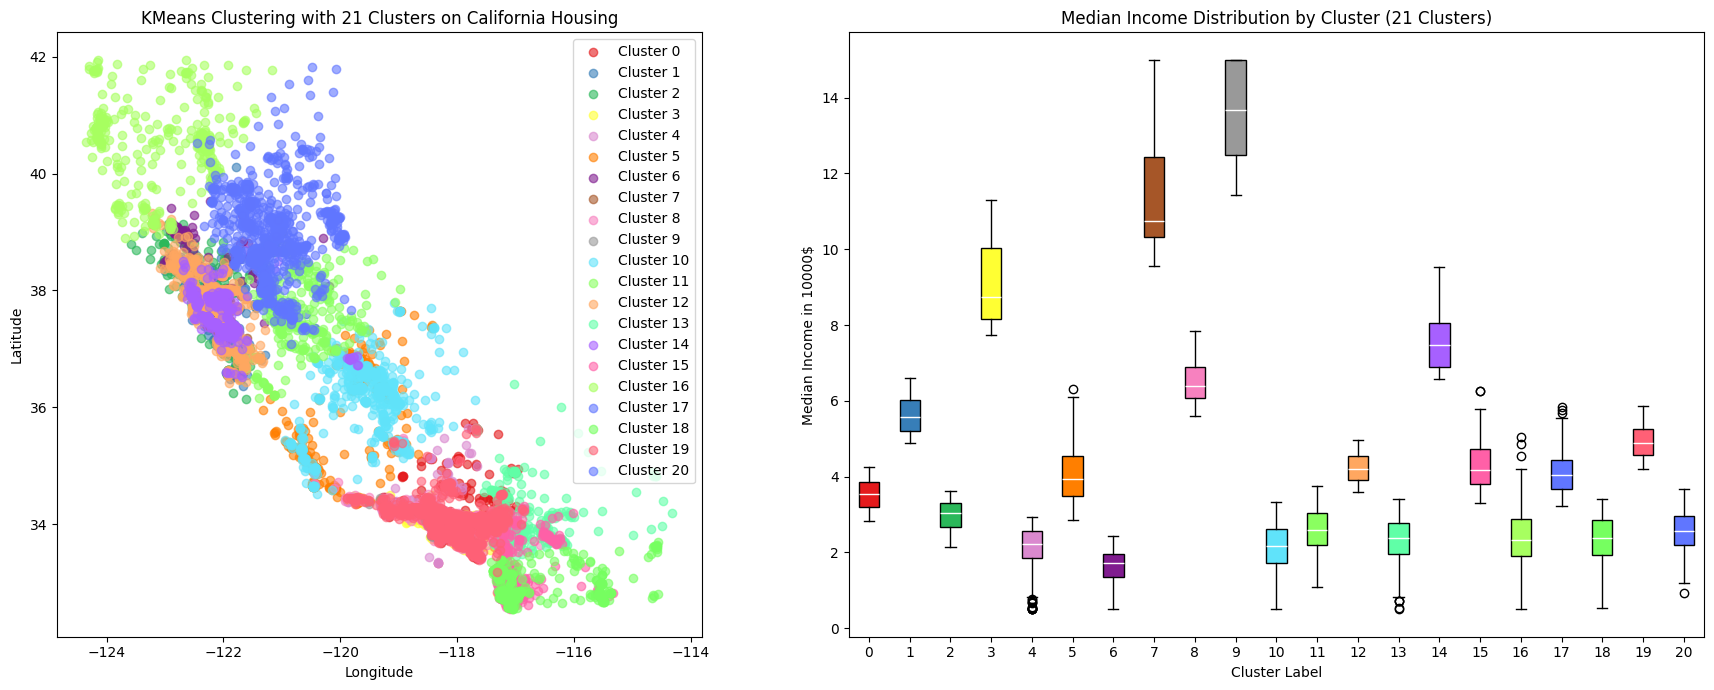

In [115]:
# Print combined cluster scatter and boxplot for multiple cluster counts (2, 3, 4, 5, 6, 7, 21)
import matplotlib.pyplot as plt
import numpy as np
colours_master = ['#e41a1c', '#377eb8', "#2bb85aff", '#ffff33', "#da89cf", '#ff7f00', "#801c8f", '#a65628', '#f781bf', '#999999', 
                  "#60E3FA", "#8AFF60", "#FFA760", "#60FFA7", "#A760FF", "#FF60A7", "#A7FF60", "#6076FF", "#76FF60", "#FF6076", "#6076FF"]
cluster_counts = [2, 3, 4, 5, 6, 7, 21]
for k in cluster_counts:
    kmeans = kmeans_per_k[k-2]  # kmeans_per_k[0] is for 2 clusters
    n_clusters = kmeans.n_clusters
    cluster_labels = kmeans.labels_
    colours = colours_master[:n_clusters]
    fig, axes = plt.subplots(1, 2, figsize=(18,7))
    # Left: scatter plot of clusters
    for cluster in range(n_clusters):
        mask = (cluster_labels == cluster)
        axes[0].scatter(housing_reduced['longitude'][mask], housing_reduced['latitude'][mask],
                       color=colours[cluster], alpha=0.6, marker='o', label=f'Cluster {cluster}')
    axes[0].set_xlabel('Longitude')
    axes[0].set_ylabel('Latitude')
    axes[0].set_title(f'KMeans Clustering with {n_clusters} Clusters on California Housing')
    axes[0].legend()
    axes[0].set_aspect('equal', adjustable='box')
    # Right: boxplot of median income by cluster
    data = [housing_reduced['median_income'][cluster_labels == i] for i in range(n_clusters)]
    box = axes[1].boxplot(data, tick_labels=[f'{i}' for i in range(n_clusters)], patch_artist=True,
                          medianprops=dict(color='white'))
    for patch, color in zip(box['boxes'], colours):
        patch.set_facecolor(color)
        patch.set_edgecolor('black')
    axes[1].set_xlabel('Cluster Label')
    axes[1].set_ylabel('Median Income in 10000$')
    axes[1].set_title(f'Median Income Distribution by Cluster ({n_clusters} Clusters)')
    plt.tight_layout()
    plt.show()

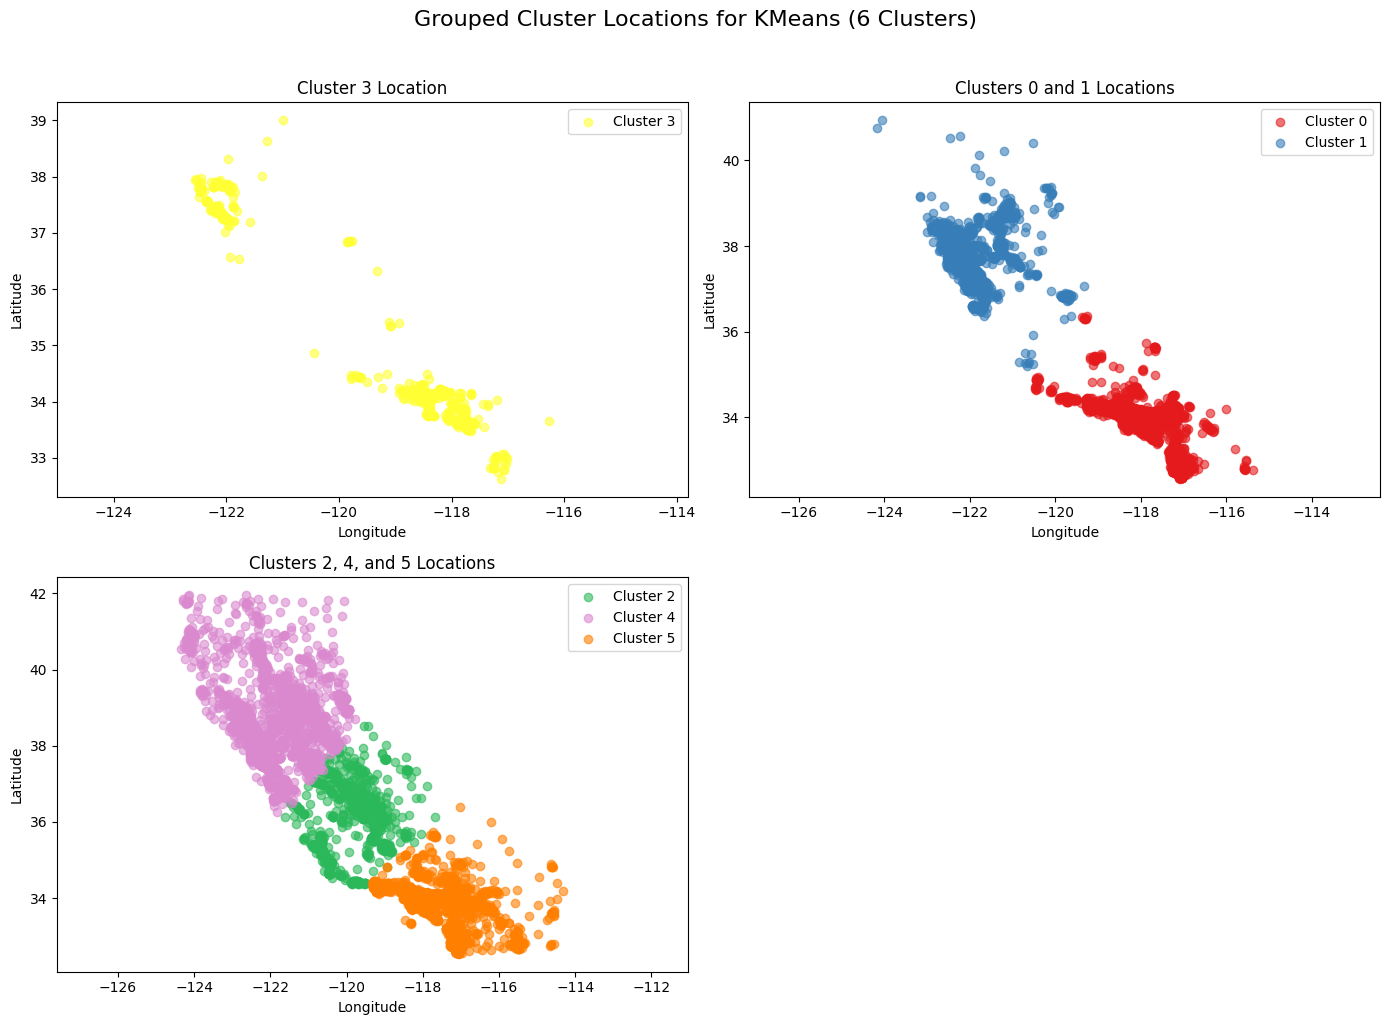

In [ ]:
# Subplots of KMeans Clusters (6 clusters) with Grouped Locations
kmeans = kmeans_per_k[4]  # 6 clusters
cluster_labels = kmeans.labels_
n_clusters = kmeans.n_clusters
# make sure we use only as many colours as clusters
colours = colours_master[:n_clusters]

# groups may contain indices that are out of range (e.g. 6 for 6 clusters -> invalid),
# so we validate and skip invalid indices to avoid IndexError
plot_groups = [
    ([3], 'Cluster 3 Location'),
    ([0, 1], 'Clusters 0 and 1 Locations'),
    ([2, 4, 5], 'Clusters 2, 4, and 5 Locations')
    #([6], 'Cluster 6 Location') # for potential future use
]

plt.figure(figsize=(14,10))
for i, (clusters, title) in enumerate(plot_groups, 1):
    ax = plt.subplot(2, 2, i)
    for cluster in clusters:
        mask = (cluster_labels == cluster)
        ax.scatter(housing_reduced['longitude'][mask], housing_reduced['latitude'][mask],
                   color=colours[cluster], alpha=0.6, marker='o', label=f'Cluster {cluster}')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(title)
    ax.legend()
    ax.set_aspect('equal', adjustable='datalim')
plt.suptitle('Grouped Cluster Locations for KMeans (6 Clusters)', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

In [66]:
# DBSCAN clustering on the scaled dataset for several eps values
from sklearn.cluster import DBSCAN
eps_values = [0.1, 0.2, 0.3, 0.4, 0.5]
for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=3)
    dbscan_labels = dbscan.fit_predict(housing_scaled)
    n_dbscan_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
    print(f'Number of clusters found by DBSCAN (eps={eps}): {n_dbscan_clusters}')

Number of clusters found by DBSCAN (eps=0.1): 165
Number of clusters found by DBSCAN (eps=0.2): 35
Number of clusters found by DBSCAN (eps=0.3): 7
Number of clusters found by DBSCAN (eps=0.4): 2
Number of clusters found by DBSCAN (eps=0.5): 2


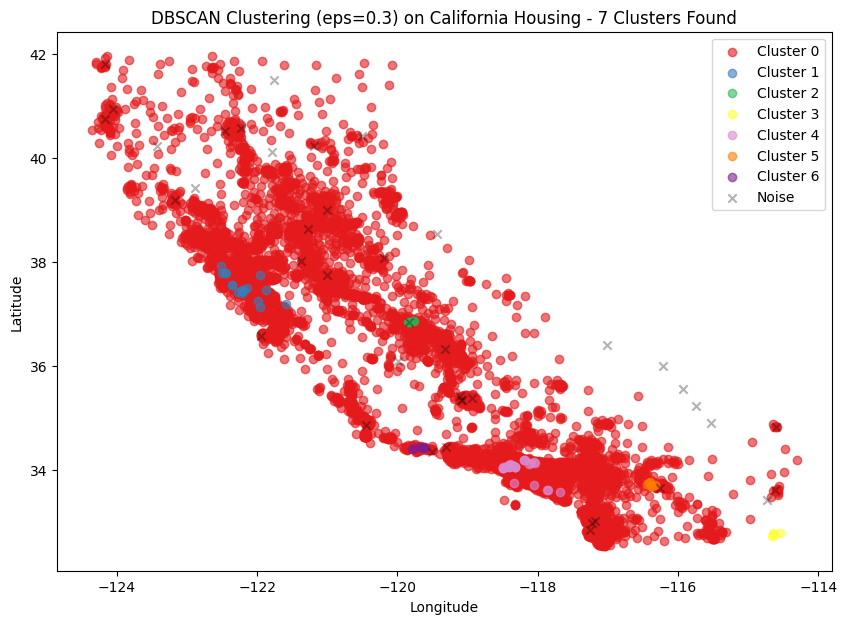

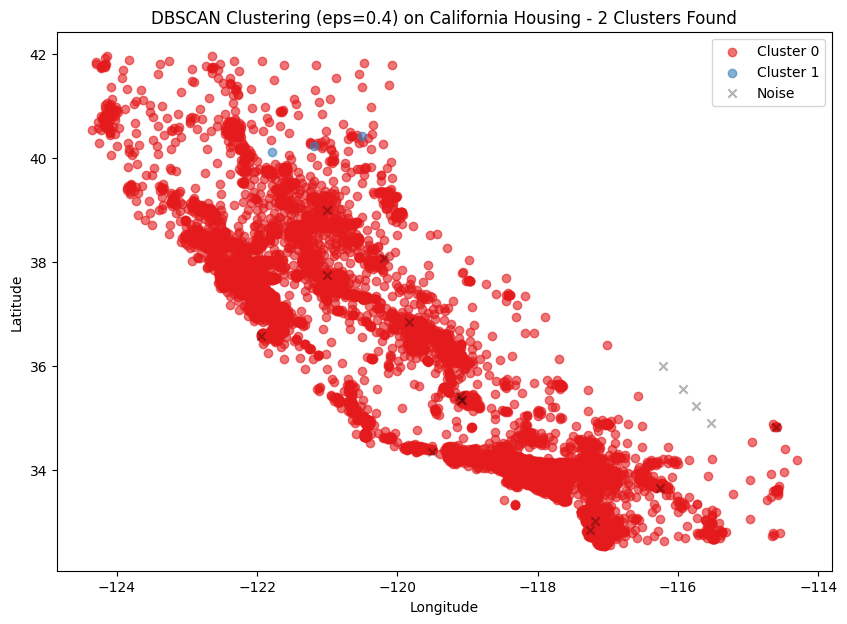

In [ ]:
# visualize DBSCAN results for multiple eps values
epsilons = [0.3, 0.4]
for eps in epsilons:
    dbscan = DBSCAN(eps=eps, min_samples=3)
    dbscan_labels = dbscan.fit_predict(housing_scaled)
    n_dbscan_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
    plt.figure(figsize=(10,7))
    for cluster in range(n_dbscan_clusters):
        mask = (dbscan_labels == cluster)
        plt.scatter(housing_reduced['longitude'][mask], housing_reduced['latitude'][mask],
                    color=colours[cluster % len(colours)], alpha=0.6, marker='o', label=f'Cluster {cluster}')
    # plot noise points if any
    noise_mask = (dbscan_labels == -1)
    if noise_mask.any():
        plt.scatter(housing_reduced['longitude'][noise_mask], housing_reduced['latitude'][noise_mask],
                    color='black', alpha=0.3, marker='x', label='Noise')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(f'DBSCAN Clustering (eps={eps}) on California Housing - {n_dbscan_clusters} Clusters Found')
    plt.legend()
    plt.show()